<a href="https://colab.research.google.com/github/audreyemmely/pln/blob/main/pln_lista5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Resolução Lista 5**

---

Audrey Emmely Rodrigues Vasconcelos

Karen Nayara Gomes da Silva

In [ ]:
from google.colab import files
uploaded = files.upload()
# upando train_data e test_data_solution

Saving test_data_solution.txt to test_data_solution.txt
Saving train_data.txt to train_data.txt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install umap-learn

     |████████████████████████████████| 86 kB 3.3 MB/s 
     |████████████████████████████████| 1.1 MB 16.7 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=fb415a4d2495b890f7b62af831b58edabacf113f5b2e4acdb669ad0aba03e8fe
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=49c54554470d560f3bf54394265f1f3947f17a7ff6b37af9ed9b2afca5f61f1a
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
Successfully built umap-learn pynndescent


In [ ]:
import pandas as pd
import numpy as np
import random
import nltk
import re
import time
import umap
from IPython.display import HTML, display
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
from sklearn.metrics import plot_confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from bokeh.palettes import Category20
from imblearn.under_sampling import RandomUnderSampler

import warnings
warnings.filterwarnings('ignore')

In [ ]:
output_notebook() 

In [ ]:
nltk.download('stopwords'); 
nltk.download('punkt');

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
df = pd.read_csv('train_data.txt', sep =':::', header = None, engine = 'python', nrows = 10000)
df.columns = ['id', 'title', 'genre', 'description']
df2 = pd.read_csv('test_data_solution.txt', sep =':::', header = None, engine = 'python', nrows = 10000)
df2.columns = ['id', 'title', 'genre', 'description']

In [ ]:
df3 = pd.concat([df, df2], ignore_index=True)
df3.drop('id', axis=1, inplace=True)
comedy = df3.loc[df3['genre'].str.contains('comedy')]
drama = df3.loc[df3['genre'].str.contains('drama')]
dataset = pd.concat([comedy, drama], ignore_index=True)

In [ ]:
def preprocess(description):
  description = re.sub(r'\w*\d\w*', '', description) #remove todas as palavras que contêm números
  description = re.sub(r'[^a-zA-Z ]', '', description.lower())
  return re.sub(r'\s+', ' ', description) #retira espaços repetidos

In [ ]:
dataset['processed_description'] = dataset.description.apply(preprocess)

In [ ]:
stop_words = set(nltk.corpus.stopwords.words('english'))
def remove_stopwords(description):
    tokenized_text = nltk.word_tokenize(description, language='english')
    return " ".join([token for token in tokenized_text if token not in stop_words])

In [ ]:
dataset['processed_description'] = dataset.processed_description.apply(remove_stopwords)

In [ ]:
dataset

,title,genre,description,processed_description
0,"""Pink Slip"" (2009)",comedy,In tough economic times Max and Joey have all...,tough economic times max joey run ideas discov...
1,Babylon Vista (2001),comedy,Frankie Reno was a child star on a TV show. B...,frankie reno child star tv show thirty years a...
2,Söderpojkar (1941),comedy,A gang of unemployed itinerant musicians play...,gang unemployed itinerant musicians play south...
3,Tunnel Vision (1976),comedy,A committee investigating TV's first uncensor...,committee investigating tvs first uncensored n...
4,"""The Young Professionals"" (2015)",comedy,"Whether it's blocking up mouse holes, running...",whether blocking mouse holes running landlords...
...,...,...,...,...
7734,Merrick (2017/I),drama,Ten years after a terrible disease has killed...,ten years terrible disease killed majority hum...
7735,Three Windows and a Hanging (2014),drama,In a traditional village where life is gradua...,traditional village life gradually rebuilt sch...
7736,Placebo (2013/II),drama,Alfred spent years as a patient in a mental i...,alfred spent years patient mental institution ...
7737,Times Square (????),drama,Set amidst the transformation of Times Square...,set amidst transformation times square new yor...


## Questão 1

O objetivo dessa questão é desenvolver um buscador de documentos.

a) escolha e aplique um modelo do tipo word2vec a seus textos, compatível com o idioma de seus textos (inglês ou português).

b) escolha 5 palavras de consulta que não estejam em nenhum dos textos. Para cada palavra de consulta, encontre as 3 palavras de seu conjunto de textos mais parecidas com cada uma das palavras de consulta e exiba os documentos onde estas palavras aparecem.

c) Seja d um documento da base e w uma palavra de consulta. Implemente o
seguinte algoritmo para buscar documentos:
1. Encontre d10(w): a lista com as 10 palavras mais parecidas com w em
um certo documento d.
2. Para cada documento d, calcule a distância média DM10(w) entre w e
as palavras de d10(w).
3. Recupere os 3 documentos da base cuja DM10(w) é menor.

d) aplique o algoritmo para buscar documentos em 5 palavras distintas, e exiba
os 3 documentos mais próximos de cada um.

In [ ]:
import gensim
from gensim.models import KeyedVectors

In [ ]:
def vocabulary(descriptions):
    vocab = ' '.join([description for description in descriptions])
    return sorted(set(vocab.split(' ')))

processed_descriptions_vocab = vocabulary(dataset.processed_description.values)

In [ ]:
import urllib.request

word_url = "https://www.mit.edu/~ecprice/wordlist.10000"
response = urllib.request.urlopen(word_url)
long_txt = response.read().decode()
words = long_txt.splitlines()

get_words = [word for word in words if word not in processed_descriptions_vocab]

In [ ]:
search_five_words = random.sample(get_words, 5)
search_five_words

['sprint', 'mongolia', 'cdna', 'projectors', 'refine']

In [ ]:
print(search_five_words in processed_descriptions_vocab)

False


In [ ]:
modelPath = open('/content/drive/MyDrive/skip_s300.txt', 'r', encoding='iso8859-1')

In [ ]:
def sim_words(search_word, n):
  similar = []
  for word in processed_descriptions_vocab:
    try:
      similarity = embedding.similarity(word, search_word)
    except:
      similarity = -1
    similar.append(similarity)
  similar = np.argsort(similar)[-(n+1):-1]
  similar = similar[::-1]
  return [processed_descriptions_vocab[i] for i in similar]

In [ ]:
print('Modelo SKIP-GRAM 300')
embedding = KeyedVectors.load_word2vec_format(modelPath)
print('Palavras mais similares')
similar_words = []
for search_word in search_five_words:
  sim_search_word = sim_words(search_word, 3)
  print(f'\t{search_word} -> {str(sim_search_word)}')
  similar_words.append({'search_word': search_word, 'similar_words': sim_search_word})

Modelo SKIP-GRAM 300
Palavras mais similares
	sprint -> ['challenge', 'volvo', 'multimedia']
	mongolia -> ['laos', 'ghana', 'yunnan']
	cdna -> ['nested', 'bacterial', 'antagonist']
	projectors -> ['chopped', 'noses', 'besieged']
	refine -> ['struggled', 'withstand', 'consented']


In [ ]:
def words_list(search_word):
  for word_list in similar_words:
    if search_word == word_list['search_word']:
      return word_list['similar_words']

def documents(word_list):
  df = []
  for word in word_list:
    dataframe = dataset[dataset.processed_description.apply(lambda description: word in description.split(' '))]
    df.append(dataframe[['title', 'description']])
  return pd.concat(df).drop_duplicates().reset_index(drop = True)

In [ ]:
for search_word in search_five_words:
  word_list = words_list(search_word=search_word)
  search_docs = documents(word_list)
  search_docs['description'] = search_docs['description'].str[:100] + '...'
  display(HTML(f'<h3>Modelo SKIP-GRAM 300<br><br>Palavra de busca [{search_word}]<br><br>Palavras similares {word_list}</h3>'))
  display(HTML(search_docs.head().to_html()))

,title,description
0,"Sorry, Thanks (2009)","Reeling from a brutal break-up, Kira sleeps with Max, a charming but disheveled wreck already commi..."
1,"""Harence"" (2016)","Stephen has just reached 1,000 subscribers on his channel, King Vulture. Not knowing what to do he ..."
2,Aapne to dhirubhai (2014),This laughter-riot is a story of young lad Dhirendra (Vrajesh Hirjee) whose role-model is business ...
3,"""Saige Winters: My Psychic Life"" (2013)","The latest comedic web series to hit YouTube, "" Saige Winters: My Psychic Life"" presents a satirica..."
4,"""Town Centre"" (2014)","Town Centre is a narrative comedy about the eccentric retailers of Town Centre, a derelict rural sh..."


,title,description
0,Lost in Laos (2012),"Daniela and Paolo decide to take a vacation in Vang Vieng in Laos, practicing tubing, rafting and h..."
1,Bodhien sivit (2006),"The film follows the experiences of Noi, a teenage girl from Laos, whose family faces financial dif..."
2,Kofi (2018),"KATRIN, a mid-30, overworked woman inherits her mother's house and decides to move in, after not ca..."
3,Anokha Milan (1972),"Tara Sen lives in a small town in India with her parents, a younger brother, sister, and an elder b..."
4,Qian li zou dan qi (2005),"In a village of fishermen in Japan, Takata misses his son Kenichi, to whom he has been estranged fo..."


,title,description
0,Co Ba Sai Gon (2017),wap to Vietnamese The re-enactment of a long dress era in the 1960s is thought to be the heyday of ...
1,Tri dnya do vesny (2017),During the siege of Leningrad a Nazi bombshell destroyed the storage of Experimental medicine insti...
2,"""Saarrthi"" (2004)",The story and characters are adapted from Mahabharata and is of conflict between two half-brothers-...


,title,description
0,Ladies Tailor (2006),"Chander is the only tailor in his colony. Though talented, he is very lazy. He dreams of becoming b..."
1,"""Day by Day"" (1988)","Six former members of ""The Brady Bunch"" cast reunited for this episode, which centered on Ross' dre..."
2,Billy Was a Deaf Kid (2009),Archie has made a discovery that will change the world forever. A toy radio. Archie's brother Billy...
3,Guai ren guai shi (1974),Former child actor and award winning Hong Kong martial-arts movie idol David Chiang directs and sta...
4,Jasmina (2010),"Asthmatic grandmother named Safa and her six-month baby granddaughter Jasmina, are transferred in a..."


,title,description
0,Chaoji 50 (2009),A comedy about ordinary people taking part in a dance competition. China hosts the Olympics for the...
1,Voyageuse (2017),"""Romance, science and conspiracy in the 20th century."" When Erica Thomas died in 2004 she left behi..."
2,El regreso (2012),"After a decade abroad, Antonio returns to Costa Rica for a short visit. Unable to run away as usual..."
3,Doo-geun-doo-geun nae-in-saeng (2014),"16 year old boy, A-Reum has Progeria Syndrome, a rare genetic defect that will cause the baby to sh..."
4,Los pobres siempre van al cielo (1951),"A pair of orphans are adopted by a couple of poor elderly, children in order to help them begin to ..."


In [ ]:
mean_vectors = []
for idx, row in dataset.iterrows():
  vectors = []
  for word in row['processed_description']:
    if word in embedding.wv.vocab:
      vectors.append(embedding.get_vector(word))
  mean_vector = np.sum(vectors, axis=0) / len(vectors)
  mean_vectors.append(mean_vector)

dataset['mean_vector'] = mean_vectors

In [ ]:
print(dataset['mean_vector'])

In [ ]:
for word in search_five_words:
  results = cosine_similarity([embedding.get_vector(word)] + mean_vectors)[0]
  results = results[1:]
  results[results.argmax()]

  print('\nPalavra <{}>: '.format(word), dataset['description'][results.argmax()])
  print()


Palavra <sprint>:   In 1924 Estie comes to Hollywood to become an actress, but the dog, that followed her becomes the star. But Hollywood has its own rules of sucess.


Palavra <mongolia>:   When Giacomo D'Amato is released from jail he is immediately employed by Magda, in a plot to secure her the heritage of the count. But there are other players in this game too, and Giacomo has his own agenda.


Palavra <cdna>:   Mail to author for translation Karasz Nelli apja halala utan hozzamegy Takaro Sanyihoz, a falu legmodosabb gazdajanak fiahoz. Bar nem szereti a ferfit, a hazassagtol tamaszt remel. Az evek multaval azonban ferje kozeledeseit egyre nehezebben viseli el, s olyan tarthatatlanna valik kapcsolatuk, hogy egy izben el is hagyja kislanyaval egyutt. Az iszony vegul vegzetes helyzetbe taszitja az asszonyt.


Palavra <projectors>:   In Episode one we are introduced to the contestants, and it turns out not all of them know what they are getting themselves into. From a mother and son t

## Questão 2
Aplicando a representação Doc2Vec:

a) Resolva a segunda questão da 3a lista com esta nova representação e compare com os resultados obtidos anteriormente.

b) Resolva a segunda e terceira questão da 4a lista com esta nova representação e compare com os resultados obtidos anteriormente.


In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [ ]:
paragraphs = dataset.processed_description.values
paragraphs = [paragraph.split(' ') for paragraph in paragraphs]

In [ ]:
docs = [TaggedDocument(doc, [i]) for i, doc in enumerate(paragraphs)]

In [ ]:
doc_embedding = Doc2Vec(docs, vector_size = 300, window = 10, min_count = 2, workers = 8)

In [ ]:
# X = np.array([doc_embedding[i] for i, description in enumerate(dataset.processed_description.values)])
X = [doc_embedding.infer_vector(u) for u in dataset['processed_description']]

In [ ]:
lbl_to_ind = {
    ' comedy ': 0, ' drama ': 1, 
}
y = [lbl_to_ind[l] for l in dataset.genre.values[:7739]]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

In [ ]:
rus = RandomUnderSampler()
X_res, y_res = rus.fit_resample(X_train, y_train)

In [ ]:
print(pd.Series(y_res).value_counts())

1    1917
0    1917
dtype: int64


In [ ]:
classifier = LogisticRegression().fit(X_res, y_res)

In [ ]:
y_pred = classifier.predict(X_test)

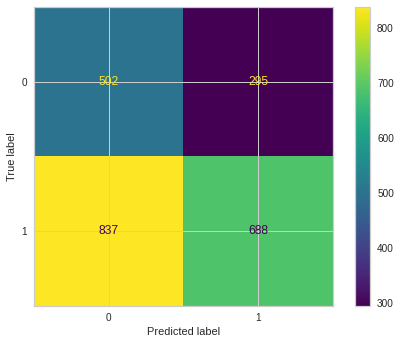

In [ ]:
plot_confusion_matrix(classifier, X_test, y_test)
plt.show()

In [ ]:
accuracy_lr = accuracy_score(y_test, y_pred)
precision_lr = precision_score(y_test, y_pred)
recall_lr = recall_score(y_test, y_pred)
f1_lr = f1_score(y_test, y_pred)

print("Modelo Regressão Logística\nAcurácia: {}\nPrecisão: {}\nRecall: {}\nF1 Score: {}\n".format(accuracy_lr, precision_lr, recall_lr, f1_lr))

Modelo Regressão Logística
Acurácia: 0.512489233419466
Precisão: 0.6998982706002035
Recall: 0.45114754098360654
F1 Score: 0.5486443381180224



In [ ]:
classifier = SVC().fit(X_res, y_res)

In [ ]:
y_pred = classifier.predict(X_test)

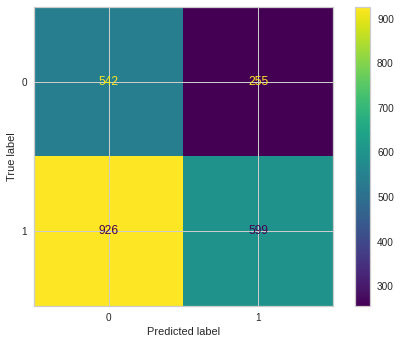

In [ ]:
plot_confusion_matrix(classifier, X_test, y_test)
plt.show()

In [ ]:
accuracy_svm = accuracy_score(y_test, y_pred)
precision_svm = precision_score(y_test, y_pred)
recall_svm = recall_score(y_test, y_pred)
f1_svm = f1_score(y_test, y_pred)

print("Modelo SVM\nAcurácia: {}\nPrecisão: {}\nRecall: {}\nF1 Score: {}\n".format(accuracy_svm, precision_svm, recall_svm, f1_svm))

Modelo SVM
Acurácia: 0.49138673557278206
Precisão: 0.7014051522248244
Recall: 0.39278688524590166
F1 Score: 0.5035729298024381



In [ ]:
lr_results = [accuracy_lr, precision_lr, recall_lr, f1_lr]
svm_results = [accuracy_svm,precision_svm, recall_svm,f1_svm]

data_results2 = {
    'Regressão Logística': lr_results,
    'SVM': svm_results,
}

index_values2 = ['accuracy', 'precision', 'recall', 'f1']
pd.set_option('display.max_columns', None)

df_results2 = pd.DataFrame(data_results2, index=index_values2)

df_results2

,Regressão Logística,SVM
accuracy,0.512489,0.491387
precision,0.699898,0.701405
recall,0.451148,0.392787
f1,0.548644,0.503573


In [ ]:
X_proj = PCA(n_components=.95).fit_transform(X)
print(X_proj.shape[1])

2


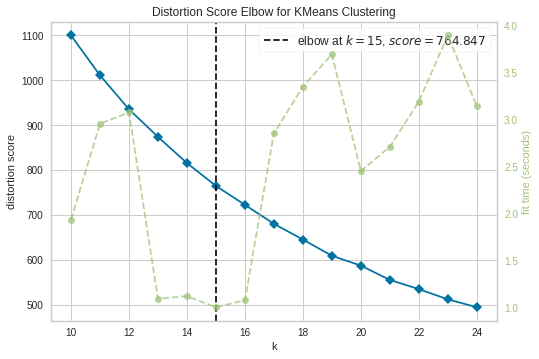

In [ ]:
visualizer = KElbowVisualizer(KMeans(), k=(10, 25), metric='distortion')
visualizer.fit(X_proj)
visualizer.show() 

In [ ]:
k = 15
kmeans = KMeans(n_clusters=k)
kmeans.fit(X_proj)

KMeans(n_clusters=15)

In [ ]:
start = time.time()
X_tsne = TSNE(n_components=2).fit_transform(X_proj)
duration = time.time() - start

In [ ]:
print('%s segundos' % duration)

90.64402151107788 segundos


In [ ]:
palette = Category20[k]

In [ ]:
def scatter_plot(X, labels):
    scatter_plot = figure(plot_width=1000, plot_height=500)
    scatter_plot.circle(X[:, 0], X[:, 1], size=10, line_color=[palette[l] for l in labels], fill_color=[palette[l] for l in labels], fill_alpha=.8)
    show(scatter_plot)

scatter_plot(X_tsne, kmeans.labels_)

In [ ]:
start = time.time()
X_umap = umap.UMAP().fit_transform(X_proj)
duration = time.time() - start

In [ ]:
print('%s segundos' % duration)

42.73649334907532 segundos


In [ ]:
scatter_plot(X_umap, kmeans.labels_)

**Referências**

[Repositório de Word Embeddings do NILC](http://www.nilc.icmc.usp.br/embeddings)

[Word2Vec — CBOW & Skip-gram : Algorithmic Optimizations](https://medium.com/analytics-vidhya/word2vec-cbow-skip-gram-algorithmic-optimizations-921d6f62d739)

[Documentation - gensim](https://radimrehurek.com/gensim/auto_examples/index.html)

[Pln repository](https://github.com/valeriojr/ecom063-pln/blob/master/Processamento%20de%20linguagem%20natural%20-%205%C2%AA%20lista%20de%20exerc%C3%ADcios.ipynb)

[NLP: Word Embedding Techniques Demystified](https://towardsdatascience.com/nlp-embedding-techniques-51b7e6ec9f92#:~:text=Doc2Vec%20is%20another%20widely%20used,every%20document%20in%20the%20corpus.)

[A gentle introduction to Doc2Vec](https://medium.com/wisio/a-gentle-introduction-to-doc2vec-db3e8c0cce5e)

[Como lidar com dados desbalanceados?](https://sigmoidal.ai/como-lidar-com-dados-desbalanceados/)